In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import display, clear_output

### Motion Optical Flow Based Heuristics

#### Mean Magnitude 

Let $ M_t $ be the segmentation mask at frame $ t $ and:

$$
\Omega_{LV} = \left\{ (x,y) \mid M_t(x,y) = 1 \right\}
$$

for each pixel $ (x,y) \in \Omega_{LV} $ we have:

$$
v(x,y) = \begin{pmatrix} v_x \\ v_y \end{pmatrix}
$$

$$
\delta(x,y) = \sqrt{v_x^2 + v_y^2} \quad \text{(magnitude)}
$$

$$
\bar{\delta} = \frac{1}{|\Omega_{LV}|} \sum_{(x,y) \in \Omega_{LV}} \delta(x,y)
$$

$$
\bar{\delta} \leq \lambda_{\text{max}} \quad \text{(validation criterion)}
$$


In [11]:
def validate_with_optical_flow(input_path, model, device,
                            threshold=0.5, mag_threshold=2.5, 
                            pixel_spacing=0.1, max_frames=100):

    def estimate_L(mask: np.ndarray, pixel_spacing: float) -> float:
        if np.sum(mask) == 0:
            return 0.0
        rows = np.where(np.any(mask == 1, axis=1))[0]
        row_base = rows[0]
        row_apex = rows[-1]
        return (row_apex - row_base) * pixel_spacing

    cap = cv2.VideoCapture(input_path)
    
    model.eval()
    frame_count = 0
    prev_mask = None
    valid_frames = []
    validation_metrics = []
    mask_areas = []
    mask_lengths = []
    
    plt.figure(figsize=(18, 6))
    
    with torch.no_grad():
        
        while cap.isOpened() and frame_count < max_frames:
            
            ret, frame = cap.read()
            if not ret:
                break
                
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_tensor = torch.from_numpy(frame_gray/255.).unsqueeze(0).unsqueeze(0).float().to(device)
            pred = model(frame_tensor)
            curr_mask = (pred > threshold).float().cpu().numpy().squeeze().astype(np.uint8)
            
            current_area = np.sum(curr_mask)
            current_length = estimate_L(curr_mask, pixel_spacing)
            
            mask_areas.append(current_area)
            mask_lengths.append(current_length)
            
            metrics = {
                'frame': frame_count,
                'mean_magnitude': 0,
                'is_valid': False,
                'mask_area': current_area,
                'mask_length': current_length
            }
            
            if prev_mask is not None:
                prev_mask_flow = (prev_mask * 255).astype(np.uint8)
                curr_mask_flow = (curr_mask * 255).astype(np.uint8)
                
                flow = cv2.calcOpticalFlowFarneback(
                    prev_mask_flow,
                    curr_mask_flow,
                    None, 0.5, 3, 15, 3, 5, 1.2, 0
                )
                
                y, x = np.where(curr_mask == 1)
                if len(y) > 0:
                    flow_vectors = flow[y, x]
                    magnitude, _ = cv2.cartToPolar(flow_vectors[...,0], flow_vectors[...,1])
                    mean_mag = np.mean(magnitude)
                    
                    metrics.update({
                        'mean_magnitude': mean_mag,
                        'is_valid': (mean_mag <= mag_threshold) 
                    })
                    
                    if metrics['is_valid']:
                        valid_frames.append(frame_count)
                
                validation_metrics.append(metrics)
                
                plt.clf()
                plt.subplot(1, 3, 1)
                plt.imshow(frame_rgb)
                plt.imshow(prev_mask, alpha=0.3, cmap='Blues')
                plt.imshow(curr_mask, alpha=0.3, cmap='Reds')
                plt.title(f'Frame {frame_count}\nBlue:Prev, Red:Curr')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                hsv = np.zeros((*curr_mask.shape, 3), dtype=np.uint8)
                if len(y) > 0:
                    mag_norm = cv2.normalize(np.sqrt(flow[...,0]**2 + flow[...,1]**2), None, 0, 255, cv2.NORM_MINMAX)
                    hsv[...,0] = np.arctan2(flow[...,1], flow[...,0]) * 180/np.pi/2
                    hsv[...,1] = 255
                    hsv[...,2] = mag_norm
                plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
                plt.title('Optical Flow Between Masks')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(frame_gray, cmap='gray')
                if len(y) > 50:
                    step = len(y)//50
                    plt.quiver(x[::step], y[::step], 
                               flow_vectors[::step,0], -flow_vectors[::step,1],
                               color='cyan', scale=10, width=0.003)
                plt.title('Flow Vectors on LV')
                plt.axis('off')
                
                plt.tight_layout()
                clear_output(wait=True)
                display(plt.gcf())
            
            prev_mask = curr_mask.copy()
            frame_count += 1
    
    cap.release()
    plt.close()
    
    if len(valid_frames) >= 2:
        volumes = []
        for area_px, length_cm in zip(mask_areas, mask_lengths):
            area_cm2 = area_px * (pixel_spacing ** 2)
            volume = area_cm2 * length_cm
            volumes.append(volume)

        edv = max(volumes)
        esv = min(volumes)
        ef = ((edv - esv) / edv) * 100

    else:
        edv, esv, ef = 0, 0, 0

    valid_count = len(valid_frames)
    total_compared = max(1, len(validation_metrics))
    
    report = f"""
    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: {input_path}
    Frames Processed: {frame_count}
    
    Validation Criteria:
      - Maximum Allowable Flow Magnitude: {mag_threshold} pixels

    Valid Frames Statistics:
      - Mean Flow Magnitude: {np.mean([m['mean_magnitude'] for m in validation_metrics if m['is_valid']]):.2f} px
      - Mean Mask Area: {np.mean([m['mask_area'] for m in validation_metrics if m['is_valid']]):.0f} px
      - Mean LV Length: {np.mean([m['mask_length'] for m in validation_metrics if m['is_valid']]):.2f} cm
    
    Results:
      - Valid Frames: {valid_count} ({valid_count/total_compared:.1%})
      - Discarded Frames: {total_compared - valid_count}
    
    Ejection Fraction Calculation:
      - EDV: {edv:.1f} ml (Frame {np.argmax(volumes) if len(volumes)>0 else 'N/A'})
      - ESV: {esv:.1f} ml (Frame {np.argmin(volumes) if len(volumes)>0 else 'N/A'})
      - EF: {ef:.1f}%
    """
    
    print(report)


In [6]:
from src.model import UNet

model = UNet()
model.load_state_dict(torch.load('../models/u-net.pth', map_location=torch.device('cpu')))

/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_31933/648112222.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/u-

<All keys matched successfully>

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

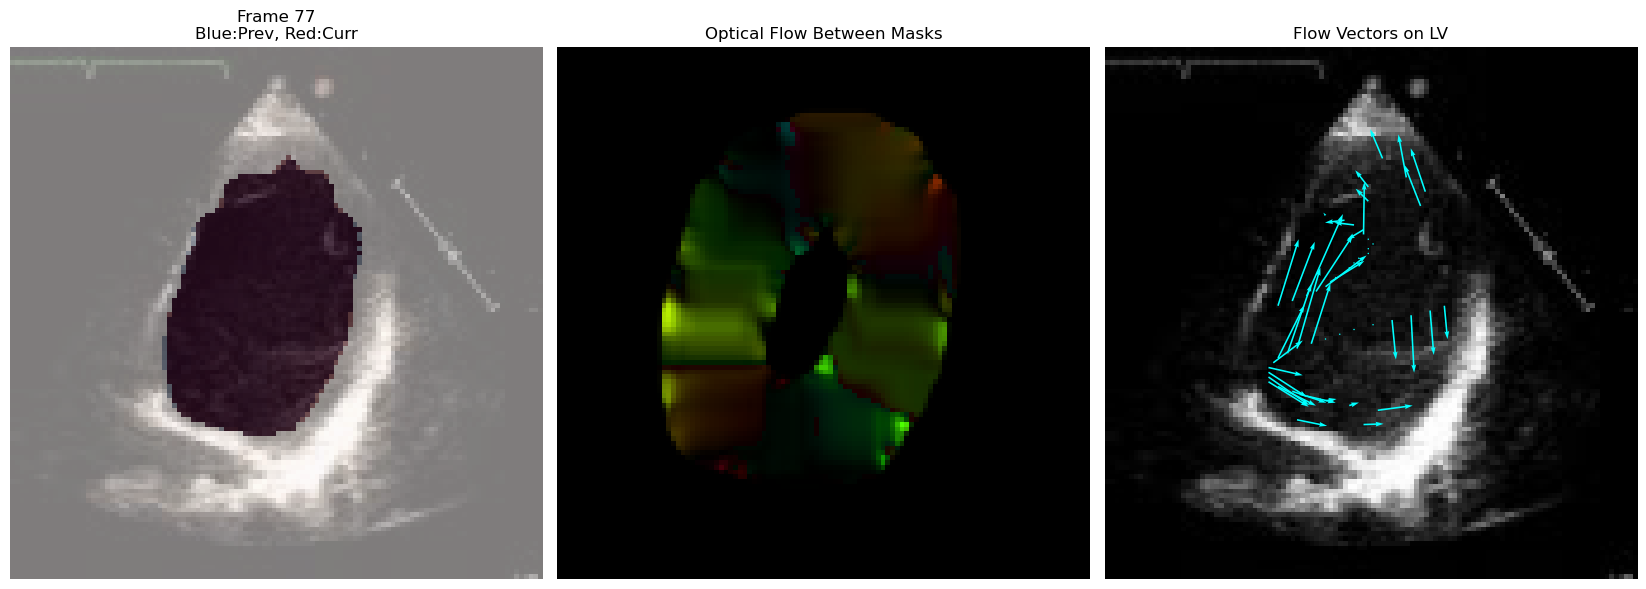


    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: ../data/echonet/A4C/videos/CR32a7579-CR3dcadf1-000063.avi
    Frames Processed: 78
    
    Validation Criteria:
      - Maximum Allowable Flow Magnitude: 2.5 pixels

    Valid Frames Statistics:
      - Mean Flow Magnitude: 1.01 px
      - Mean Mask Area: 1502 px
      - Mean LV Length: 5.12 cm
    
    Results:
      - Valid Frames: 75 (97.4%)
      - Discarded Frames: 2
    
    Ejection Fraction Calculation:
      - EDV: 110.8 ml (Frame 40)
      - ESV: 47.4 ml (Frame 25)
      - EF: 57.2%
    


In [12]:
validate_with_optical_flow("../data/echonet/A4C/videos/CR32a7579-CR3dcadf1-000063.avi", model, device)